# Business Data Solutions Analytics for TikTok

> ## Kedir Nasir Omer



In [ ]:
# Install some necessary libraries
!pip install -q --upgrade clean-text[gpl]
!pip install -q transformers

In [ ]:
# Import necessary libraries
import os
import requests
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
import string
import re
from bs4 import BeautifulSoup
from cleantext import clean
from PIL import Image
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy import ndimage
import random
from IPython.display import display, HTML, Markdown
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px

# Download the stopwords from nltk
nltk.download('stopwords')

# Set the stemmer
stemmer = nltk.SnowballStemmer("english")

nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Read the data from the csv file
# Load the file from google drive
# Mount Google Drive to my Colab runtime
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/tiktok_google_play_reviews.csv")

# Set display options to show grid lines in tables
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.html.table_schema', True)

# Select 10 random rows from the data
random_rows = data.sample(n=10)

# Display the selected rows as a table
display(HTML(random_rows.to_html(index=False)))

Mounted at /content/drive


<ipython-input-6-4d75fb66411c>:5: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/tiktok_google_play_reviews.csv")


reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
66bbaac7-1582-428f-9054-990768f7af11,ICEcoldASSASIN7,https://play-lh.googleusercontent.com/a-/ACNPEu_3oRsVpFR1LP-0JkfrJDkfI5ohY26HQnHcWiydnQ,Garbage app,1,0,NaN,2022-09-19 16:27:11,NaN,NaN
9f52a6bc-a46a-4ea1-a614-c1866d730e87,Chelsea Davis,https://play-lh.googleusercontent.com/a/ALm5wu3Ks5fxkG293gtt9SOGYqBsZQsYPUrypdrzBS0F=mo,But l can't update it,5,0,26.7.5,2022-11-02 15:47:37,NaN,NaN
c5b8fda2-8435-42f7-ab93-7702a6d88d7d,Xane Up,https://play-lh.googleusercontent.com/a-/ACNPEu82d07l24QJn3XSf1gNs9sZE7n35XwGw5ctaKo_,It's dope!!!,5,0,NaN,2022-07-05 19:50:04,NaN,NaN
1a0bf918-7477-4ab0-881f-3fed78d926b2,hzalhabibkr Sinha,https://play-lh.googleusercontent.com/a-/ACNPEu-eEnniD-qIXkmVicyuNIC9TIoDN79kgQUOiEhF,ভেরি ভেরি নাইচ,5,0,25.3.4,2022-07-20 04:45:50,NaN,NaN
921d3604-91a0-4f41-babb-31fa61e7dc04,Romantic Valobasa,https://play-lh.googleusercontent.com/a-/ACNPEu8DXql1Bl1cvcIX6wJMShqQ-612qjKXp0eafiOB,Nice,5,0,24.6.3,2022-06-21 19:05:42,NaN,NaN
cd5fbfe9-09a9-4a9a-899f-11f5694ba59c,Abdulmaleek Bello,https://play-lh.googleusercontent.com/a/ALm5wu0x59xMIP7HfWGOhD7aQ5G92uyFUvd651Lc8MM7=mo,I really love this app it work nice,5,0,26.9.3,2022-11-12 06:57:45,NaN,NaN
0d9b6210-81bf-41d0-8728-5ecb5ac49a1a,Lùñá_ Møøn,https://play-lh.googleusercontent.com/a-/ACNPEu_znLEir8N5Wm5XGcmKacak4kxVFyF87IzcC_rnqQ,Can be kind of annoying at times but is overall a good app that I would recommend.,4,0,26.9.4,2022-11-26 20:17:39,NaN,NaN
7565f359-7830-49ed-95df-7e4f38965916,Sean Daniel,https://play-lh.googleusercontent.com/a-/ACNPEu9L3Icm-Vr6z_8njx75wOVr0d7UycRjx8EiDcMo,"Well so I like the app but I can't login anymore because it keeps saying ""to many attempts, try again"" everytime I try, even when I wait a day",3,0,25.6.4,2022-08-11 23:57:47,NaN,NaN
5e876f27-d32c-451c-a138-439dfb6c3cd0,chante walker,https://play-lh.googleusercontent.com/a/ALm5wu1vlcN7QHKsAaQC6pqkygRoAJ7u5XZmUYnQIHUa=mo,You band my account becouse apparently I'm 13 pr younger but I'm almost 15 so way the hell did you band my account there is widios i dont want to lose,2,0,26.6.4,2022-10-24 09:35:29,NaN,NaN
1cfb120c-31a7-48fe-9caf-68490b111e11,Eliseo Vasquez,https://play-lh.googleusercontent.com/a-/ACNPEu8nn-ypFvQQLIsavwbige-HRPo5dHqcGDrZz01qsg,Good experience on this app,5,0,26.3.3,2022-09-24 14:03:30,NaN,NaN


In [ ]:
# Perform EDA on the data
display(Markdown(f"**dataset shape:**"))
print("Shape of the data:", data.shape)

display(Markdown(f"**dataset size:**"))
print("Size of the data:", data.size)

display(Markdown(f"**data info:**"))
print(data.info())

display(Markdown(f"**data statistics:**"))
print(data.describe())

display(Markdown(f"**columns unique values:**"))
print("Columns unique values:")
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

**dataset shape:**

Shape of the data: (460287, 10)


**dataset size:**

Size of the data: 4602870


**data info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460287 entries, 0 to 460286
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              460287 non-null  object
 1   userName              460287 non-null  object
 2   userImage             460287 non-null  object
 3   content               460271 non-null  object
 4   score                 460287 non-null  int64 
 5   thumbsUpCount         460287 non-null  int64 
 6   reviewCreatedVersion  333953 non-null  object
 7   at                    460287 non-null  object
 8   replyContent          260 non-null     object
 9   repliedAt             260 non-null     object
dtypes: int64(2), object(8)
memory usage: 35.1+ MB
None


**data statistics:**

               score  thumbsUpCount
count  460287.000000  460287.000000
mean        4.234919       3.210601
std         1.430718     183.506791
min         1.000000       0.000000
25%         4.000000       0.000000
50%         5.000000       0.000000
75%         5.000000       0.000000
max         5.000000   40311.000000


**columns unique values:**

Columns unique values:
reviewId: 460287 unique values
userName: 406759 unique values
userImage: 458973 unique values
content: 278477 unique values
score: 5 unique values
thumbsUpCount: 692 unique values
reviewCreatedVersion: 631 unique values
at: 452242 unique values
replyContent: 81 unique values
repliedAt: 260 unique values


score
1     61928
2     13180
3     18620
4     27665
5    338894
dtype: int64


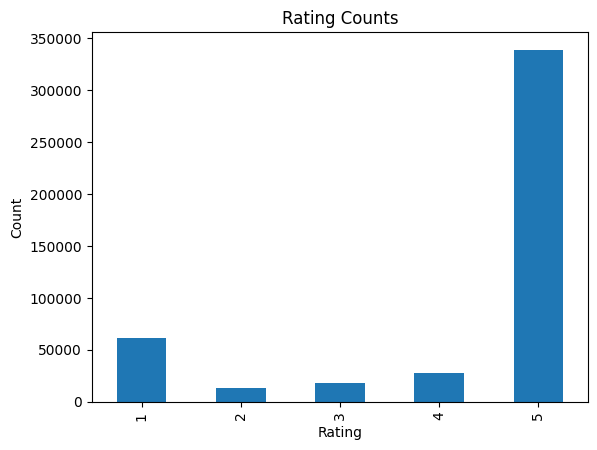

In [ ]:
# Rating counts
counts = data.groupby('score').size()
print(counts)

counts.plot.bar()
plt.title('Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# Define a function to preprocess/clean the text
def preprocess_text(text):
    """
    Preprocesses the given text by removing null values, filling missing values,
    removing URLs, emojis, punctuation, and converting to lowercase.

    :param text: str, the text to be preprocessed
    :return: str, the preprocessed text
    """

    # Handle null or NaN values by returning an empty string
    if not isinstance(text, str) or not text:
        return ''

    # Remove URLs, emojis, punctuation, HTML tags, and convert to lowercase using cleantext library
    text = clean(text, fix_unicode=True, no_urls=True, no_emoji=True, no_punct=True, lower=True)

    # Return the preprocessed/cleaned text
    return text

# Apply the preprocess_text function to the 'content' column of the data
data['content'] = data['content'].apply(preprocess_text)

In [ ]:
# Check for missing values in the data
print(data.isnull().sum())
data = data.dropna().fillna('')

reviewId                     0
userName                     0
userImage                    0
content                      0
score                        0
thumbsUpCount                0
reviewCreatedVersion    126334
at                           0
replyContent            460027
repliedAt               460027
dtype: int64


In [ ]:
# Load the pre-trained model and tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Define a function to calculate sentiment scores using the pre-trained model
def calculate_sentiment_scores(review):
    """
    Calculates sentiment scores for each review using the pre-trained model from Hugging Face.

    :param review: str, review for which sentiment scores are to be calculated.
    :return: dict containing positive, negative and neutral sentiment scores.
    """

    # Handle empty or NaN reviews by returning a dictionary with default values for the sentiment scores
    if not isinstance(review, str) or not review:
        return {'positive': 0.0, 'negative': 0.0, 'neutral': 1.0}

    # Tokenize the review using the pre-trained tokenizer
    inputs = tokenizer(review, return_tensors="pt")

    # Calculate sentiment scores using the pre-trained model
    outputs = model(**inputs)
    scores = outputs[0][0].detach().numpy()
    scores = torch.nn.functional.softmax(torch.tensor(scores), dim=0).numpy()

    # Return sentiment scores
    return {'positive': scores[4], 'negative': scores[0], 'neutral': scores[2]}

# Calculate sentiment scores for each review in 'content' column of data DataFrame.
data[['positive', 'negative', 'neutral']] = data['content'].apply(calculate_sentiment_scores).apply(pd.Series)

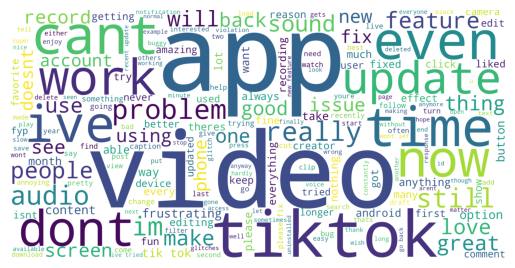

In [ ]:
# Create a wordcloud to view the whole reviews with a higher scale and larger size
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, scale=2, width=1600, height=800).generate(' '.join(data['content']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

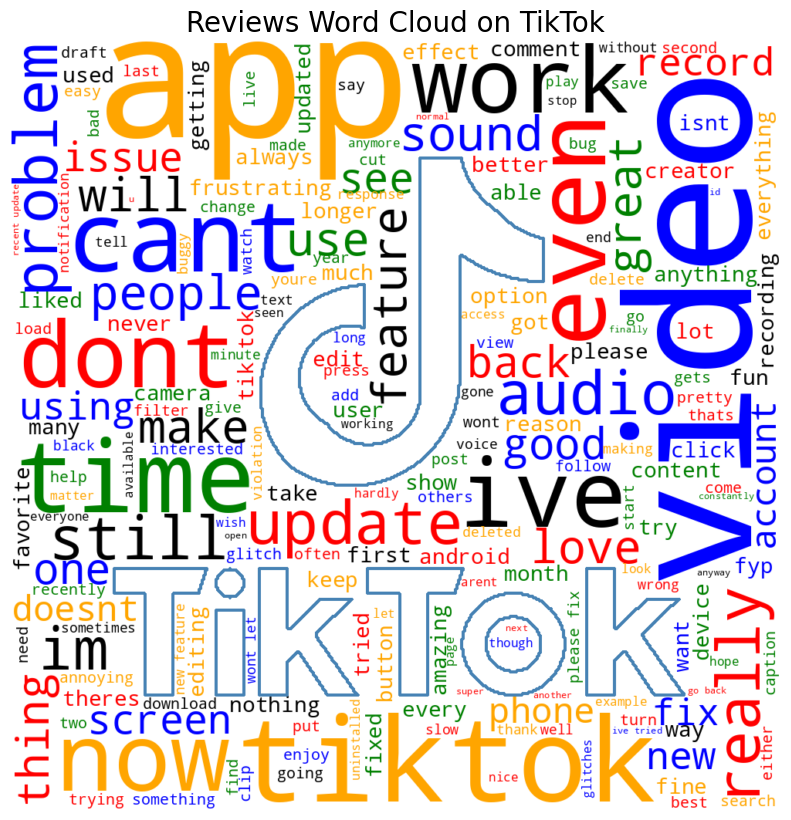

In [ ]:
# Display a word cloud inside TikTok logo
# Set image URL and pull the image
image_url = 'https://raw.githubusercontent.com/kedibeki/Advanced-Business-Data-Solutions-Analytics-for-TikTok-foryou/main/TikTok_Logo-removebg-preview.png'
tiktok_mask = np.array(Image.open(requests.get(image_url, stream=True).raw))

# Define a custom color function that returns colors from a predefined list of colors
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Define the list of colors to use
    colors = ["green", "black", "red", "blue", "orange"]

    # Choose a random color from the list
    color = random.choice(colors)

    return color

# Generate the word cloud with a higher scale
wc = WordCloud(background_color='white', mask=tiktok_mask, contour_width=3, contour_color='steelblue', width=800, height=400, scale=2).generate(' '.join(data['content']))

# Plot the word cloud
plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=custom_color_func), interpolation='bilinear')
plt.axis("off")

# Add a title to the plot with a larger font size
plt.title("Reviews Word Cloud on TikTok", fontsize=20)

plt.show()

In [ ]:
# Extract the x, y, and z values from the data
x = data.index
y = data['positive']
z = data['negative']
w = data['neutral']

# Define offsets for each sentiment category
offset_positive = -0.2
offset_negative = 0
offset_neutral = 0.2

# Create traces for each sentiment category
trace1 = go.Scatter3d(
    x=x + offset_positive, y=y, z=z,
    mode='markers',
    name='Positive',
    marker=dict(size=3, color='green')
)
trace2 = go.Scatter3d(
    x=x + offset_negative, y=y, z=z,
    mode='markers',
    name='Negative',
    marker=dict(size=3, color='red')
)
trace3 = go.Scatter3d(
    x=x + offset_neutral, y=y, z=w,
    mode='markers',
    name='Neutral',
    marker=dict(size=3, color='yellow')
)

# Create a Figure object
fig = go.Figure(data=[trace1, trace2, trace3])

# Center the title of the 3D scatter plot
fig.update_layout(title={
    'text': 'Reviews Category 3D Scatter Plot',
    'x': 0.47,
    'xanchor': 'center'
})

# Show the plot
fig.show()

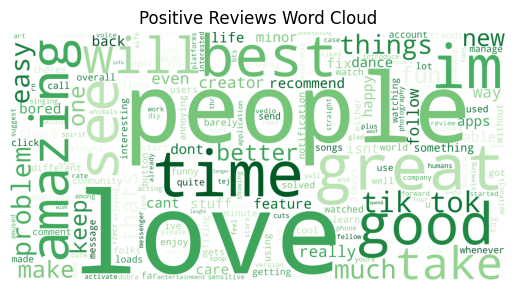

In [ ]:
# Define a custom set of stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['video', 'app', 'videos', 'tiktok'])

# Create word clouds for positive reviews with relative scaling, green colors, and larger size
positive_reviews = data[data['positive'] > data[['negative', 'neutral']].max(axis=1)]
positive_wordcloud = WordCloud(background_color='white', stopwords=custom_stopwords, relative_scaling=0.5, colormap='Greens', scale=2, width=1600, height=800).generate(' '.join(positive_reviews['content']))
plt.imshow(positive_wordcloud)
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

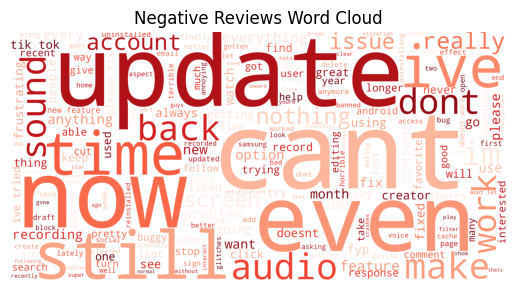

In [ ]:
# Define a custom set of stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['video', 'app', 'videos', 'tiktok'])

# Create word clouds for negative reviews with relative scaling, red colors, and larger size
negative_reviews = data[data['negative'] > data[['positive', 'neutral']].max(axis=1)]
negative_wordcloud = WordCloud(background_color='white', stopwords=custom_stopwords, relative_scaling=0.5, colormap='Reds', scale=2, width=1600, height=800).generate(' '.join(negative_reviews['content']))
plt.imshow(negative_wordcloud)
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

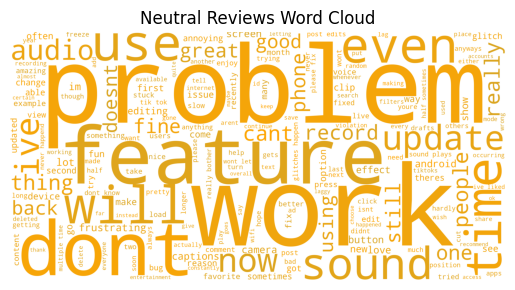

In [ ]:
# Define a custom set of stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['video', 'app', 'videos', 'tiktok'])

# Define the colors for the custom colormap
colors = ["goldenrod", "orange"]

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Create word clouds for neutral reviews with relative scaling, golden and orange colors, and larger size
neutral_reviews = data[data['neutral'] > data[['positive', 'negative']].max(axis=1)]
neutral_wordcloud = WordCloud(background_color='white', stopwords=custom_stopwords, relative_scaling=0.5, colormap=cmap, scale=2, width=1600, height=800).generate(' '.join(neutral_reviews['content']))
plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title('Neutral Reviews Word Cloud')
plt.show()

In [ ]:
# Create a pie plot to show the percentage of positive, negative, and neutral reviews with custom colors
sentiment_counts = data[['positive', 'negative', 'neutral']].idxmax(axis=1).value_counts()[['positive', 'negative', 'neutral']]
# Sort sentiment_counts in ascending order
sentiment_counts = sentiment_counts.sort_values(ascending=True)
fig = go.Figure(
    data=[go.Pie(
        labels=sentiment_counts.index,
        values=sentiment_counts.values,
        marker=dict(colors=['green', 'yellow', 'red']),
        sort=False
    )]
)
fig.update_traces(textposition='inside', textinfo='percent+label')

# Add a title to the pie chart
# Center the title and add an indent
fig.update_layout(
    title={
        'text': 'Percentage of Reviews Category',
        'x': 0.46,  # Center the title
        'xanchor': 'center'
    },
    margin=dict(l=50)  # Add an indent to the left side of the plot
)

fig.show()

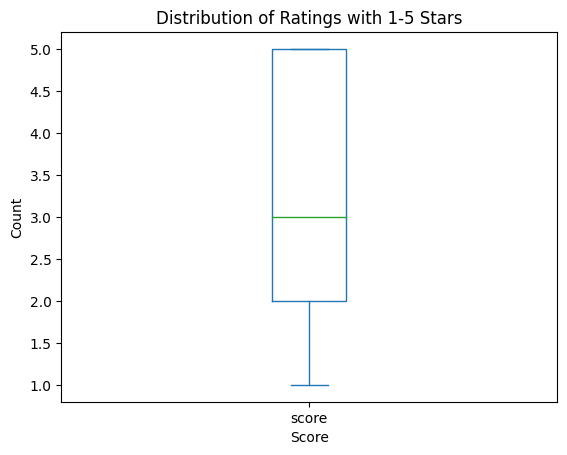

In [ ]:
# Create a box plot to show the distribution of ratings with 1-5 stars
data['score'].plot.box()
plt.title('Distribution of Ratings with 1-5 Stars')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()